### this script is to extract events using odds ratio, do calibration based on the templates and finally plot the figures that will be needed in the paper

In [1]:
import pandas as pd
df_m = pd.read_csv("data/ee-fm/df_m.csv")
df_f = pd.read_csv("data/ee-fm/df_f.csv")

In [2]:
import itertools
import spacy
import ast 

# nlp = spacy.load('en') # JULIE edits: remove nlp and replace nlp with sp
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

def chain(array):
    array = ast.literal_eval(array)
    return list(itertools.chain.from_iterable(array))

def events_only(array):
    events = []
    if(len(array) > 0):
        for event in array:
            trigger_word = event["triggers"][0]["text"]
            w = sp(trigger_word)
            if w[0].lemma_ not in all_stopwords:
                events.append(w[0].lemma_)
    return events

In [3]:
df_f

,Unnamed: 0,Unnamed: 0.1,name,name_url,gender,person_info,personal_life,career,occupation,pl_events,pl_ev_lemma,career_events,career_ev_lemma
0,0,0,Jody Adams (chef),https://en.wikipedia.org/wiki/Jody_Adams_(chef),F,"[{'section': 'Career', 'info': ['In 2011, Adam...",[],"[[{'event_type': 'Business:Start-Org', 'trigge...",chefs,[],[],"[{'event_type': 'Business:Start-Org', 'trigger...","['open', 'open', 'provide', 'illustrate']"
1,1,1,Einat Admony,https://en.wikipedia.org/wiki/Einat_Admony,F,"[{'section': 'Early life', 'info': ['Admony is...",[],"[[{'event_type': 'Business:Start-Org', 'trigge...",chefs,[],[],"[{'event_type': 'Business:Start-Org', 'trigger...","['open', 'introduce', 'list', 'appear', 'retur..."
2,2,2,Karen Akunowicz,https://en.wikipedia.org/wiki/Karen_Akunowicz,F,"[{'section': 'References', 'info': []}]",[],[],chefs,[],[],[],[]
3,3,3,Devin Alexander,https://en.wikipedia.org/wiki/Devin_Alexander,F,"[{'section': 'Biography', 'info': ['In 2006, s...",[],[],chefs,[],[],[],[]
4,4,4,Fatima Ali,https://en.wikipedia.org/wiki/Fatima_Ali,F,"[{'section': 'Early life', 'info': [""Fatima Al...",[],"[[{'event_type': '', 'triggers': [{'event_type...",chefs,[],[],"[{'event_type': '', 'triggers': [{'event_type'...","['continue', 'begin', 'win', 'vote', 'finish']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271,5271,925,Diana Wynyard,/wiki/Diana_Wynyard,F,"[{'section': 'Life and career', 'info': ['Born...","[[{'event_type': 'Life:Marry', 'triggers': [{'...",[],acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'die', 'rehearse', 'replace', 'dea...",[],[]
5272,5272,926,Susannah York,/wiki/Susannah_York,F,"[{'section': 'Early life', 'info': [""York was ...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[{'event_type': '', 'triggers': [{'event_type...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'divorce', 'bear', 'play', 'evoke'...","[{'event_type': '', 'triggers': [{'event_type'...","['play', 'begin', 'perform', 'agree', 'appear'..."
5273,5273,929,Loretta Young,/wiki/Loretta_Young,F,"[{'section': 'Early life', 'info': ['She was b...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[], [{'event_type': 'Life:Marry', 'triggers':...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'marriage', 'marriage', 'married',...","[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'marriage', 'marry', 'annul', 'elo..."
5274,5274,931,Renée Zellweger,/wiki/Ren%C3%A9e_Zellweger,F,"[{'section': 'Early life', 'info': ['Renée Kat...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[{'event_type': 'Life:Die', 'triggers': [{'ev...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","['married', 'engage', 'obtain', 'meet', 'separ...","[{'event_type': 'Life:Die', 'triggers': [{'eve...","['kill', 'receive', 'note', 'applaud', 'play',..."


In [4]:
def extract_events(df_nomi_female):
    # JULIE edits: comment out the first four lines because they are already calculated in the provided dfs
    # no need to redo 
    # saves computation power/cost 
#     df_nomi_female["pl_events"] = df_nomi_female["personal_life"].apply(ast.literal_eval)
#     df_nomi_female["pl_ev_lemma"] = df_nomi_female["pl_events"].apply(ast.literal_eval)
#     df_nomi_female["career_events"] = df_nomi_female["career"].apply(chain)
#     df_nomi_female["career_ev_lemma"] = df_nomi_female["career_events"].apply(events_only)
    df_nomi_female["career_ev_lemma"] = df_nomi_female["career_ev_lemma"].apply(ast.literal_eval)
    df_nomi_female["pl_ev_lemma"] = df_nomi_female["pl_ev_lemma"].apply(ast.literal_eval)
    df_nomi_female["pl_ev_num"] = df_nomi_female["pl_ev_lemma"].apply(len)
    df_nomi_female["cr_ev_num"] = df_nomi_female["career_ev_lemma"].apply(len)
    return df_nomi_female

## odds ratio calculation function
### *--------------------------------------------------------*

In [5]:
from collections import OrderedDict
def odds_ratio(f_dict, m_dict, topk=50, threshold=2):
    very_small_value = 0.00001
    if len(f_dict.keys()) != len(m_dict.keys()):
        raise Exception("The category for analyzing the male and female should be the same!")
    else:
        odds_ratio = {}
        total_num_f = sum(f_dict.values())
        total_num_m = sum(m_dict.values())
        for key in f_dict.keys():
            m_num = m_dict[key]
            f_num = f_dict[key]
            non_f_num = total_num_f - f_num
            non_m_num = total_num_m - m_num
            if f_num >= threshold and m_num >= threshold:
                # we only consider the events where there are at least {thresohld} occurences for both gender
                odds_ratio[key] = round((m_num / f_num) / (non_m_num / non_f_num), 2)
            else:
                continue
        return OrderedDict(sorted(odds_ratio.items(), key=itemgetter(1), reverse=True)[:topk]), \
            OrderedDict(sorted(odds_ratio.items(), key=itemgetter(1))[:topk])

### *--------------------------------------------------------*

In [6]:
import pickle
import itertools
import spacy
from operator import itemgetter
from collections import Counter
import logging
from datetime import datetime
import numpy as np

In [7]:
df_m = extract_events(df_m)
df_f = extract_events(df_f)

In [8]:
(df_f['pl_ev_num'] > 0).value_counts(normalize=True)

False    0.678165
True     0.321835
Name: pl_ev_num, dtype: float64

In [9]:
((df_f['pl_ev_num'] == 0) | (df_f['cr_ev_num'] == 0)).value_counts(normalize=True)

True     0.778999
False    0.221001
dtype: float64

In [10]:
((df_m['pl_ev_num'] == 0) | (df_m['cr_ev_num'] == 0)).value_counts(normalize=True)

True     0.824777
False    0.175223
dtype: float64

In [11]:
(df_f['cr_ev_num'] > 0).value_counts(normalize=True)

False    0.583776
True     0.416224
Name: cr_ev_num, dtype: float64

In [12]:
(df_m['cr_ev_num'] > 0).value_counts(normalize=True)

False    0.636761
True     0.363239
Name: cr_ev_num, dtype: float64

In [13]:
(df_m['pl_ev_num'] > 0).value_counts(normalize=True)

False    0.733441
True     0.266559
Name: pl_ev_num, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pl_ev_num', ylabel='Density'>

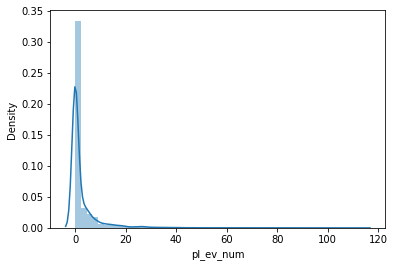

In [14]:
import seaborn as sns
sns.distplot(df_f['pl_ev_num'])

In [15]:
df_f

,Unnamed: 0,Unnamed: 0.1,name,name_url,gender,person_info,personal_life,career,occupation,pl_events,pl_ev_lemma,career_events,career_ev_lemma,pl_ev_num,cr_ev_num
0,0,0,Jody Adams (chef),https://en.wikipedia.org/wiki/Jody_Adams_(chef),F,"[{'section': 'Career', 'info': ['In 2011, Adam...",[],"[[{'event_type': 'Business:Start-Org', 'trigge...",chefs,[],[],"[{'event_type': 'Business:Start-Org', 'trigger...","[open, open, provide, illustrate]",0,4
1,1,1,Einat Admony,https://en.wikipedia.org/wiki/Einat_Admony,F,"[{'section': 'Early life', 'info': ['Admony is...",[],"[[{'event_type': 'Business:Start-Org', 'trigge...",chefs,[],[],"[{'event_type': 'Business:Start-Org', 'trigger...","[open, introduce, list, appear, return, compet...",0,8
2,2,2,Karen Akunowicz,https://en.wikipedia.org/wiki/Karen_Akunowicz,F,"[{'section': 'References', 'info': []}]",[],[],chefs,[],[],[],[],0,0
3,3,3,Devin Alexander,https://en.wikipedia.org/wiki/Devin_Alexander,F,"[{'section': 'Biography', 'info': ['In 2006, s...",[],[],chefs,[],[],[],[],0,0
4,4,4,Fatima Ali,https://en.wikipedia.org/wiki/Fatima_Ali,F,"[{'section': 'Early life', 'info': [""Fatima Al...",[],"[[{'event_type': '', 'triggers': [{'event_type...",chefs,[],[],"[{'event_type': '', 'triggers': [{'event_type'...","[continue, begin, win, vote, finish]",0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271,5271,925,Diana Wynyard,/wiki/Diana_Wynyard,F,"[{'section': 'Life and career', 'info': ['Born...","[[{'event_type': 'Life:Marry', 'triggers': [{'...",[],acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","[married, die, rehearse, replace, death, occur...",[],[],7,0
5272,5272,926,Susannah York,/wiki/Susannah_York,F,"[{'section': 'Early life', 'info': [""York was ...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[{'event_type': '', 'triggers': [{'event_type...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","[married, divorce, bear, play, evoke, support,...","[{'event_type': '', 'triggers': [{'event_type'...","[play, begin, perform, agree, appear, play, fe...",8,35
5273,5273,929,Loretta Young,/wiki/Loretta_Young,F,"[{'section': 'Early life', 'info': ['She was b...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[], [{'event_type': 'Life:Marry', 'triggers':...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","[married, marriage, marriage, married, married...","[{'event_type': 'Life:Marry', 'triggers': [{'e...","[married, marriage, marry, annul, elope, bill,...",26,28
5274,5274,931,Renée Zellweger,/wiki/Ren%C3%A9e_Zellweger,F,"[{'section': 'Early life', 'info': ['Renée Kat...","[[{'event_type': 'Life:Marry', 'triggers': [{'...","[[{'event_type': 'Life:Die', 'triggers': [{'ev...",acting,"[{'event_type': 'Life:Marry', 'triggers': [{'e...","[married, engage, obtain, meet, separate, star...","[{'event_type': 'Life:Die', 'triggers': [{'eve...","[kill, receive, note, applaud, play, plan, rec...",11,75


In [16]:
def calculate_dict(female_array, male_array):
    counter_f_h = Counter(female_array)
    counter_m_h = Counter(male_array)
    
    # make sure there is no key lookup error
    for key in set(counter_f_h) - set(counter_m_h):
        counter_m_h[key] = 0
    for key in set(counter_m_h) - set(counter_f_h):
        counter_f_h[key] = 0

    return counter_f_h, counter_m_h

In [17]:
def counter_odds_career(career_evs_female, career_evs_male):
    counter_f_c, counter_m_c = calculate_dict(career_evs_female, career_evs_male)
    odds_m_c, odds_f_c = odds_ratio(counter_f_c, counter_m_c)
    return counter_f_c, counter_m_c, odds_m_c, odds_f_c

def check_keyword(array):
    return keyword in array

In [18]:
# there are two ways to do the chain list function: one is applicable to career
# the other is applicable to the personal life section, please choose the one based on the data
# def chain_list(array):
#     array_new = []
#     for i in array:
#         array_new.append(ast.literal_eval(i))
#     return (list(itertools.chain.from_iterable(array_new)))

# JULIE edits: commenting out this second definition of the function
# because the first one works with the data format, not the second
# this is also extremely poor programming practice

def chain_list(array):
    return list(itertools.chain.from_iterable(array))

In [21]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
result_counter = {}
result_odds = {}
for new_occupation in new_occupations:
    print("occupation: ", new_occupation)
    df_m_occ, df_f_occ = df_m[df_m["occupation"] == new_occupation], df_f[df_f["occupation"] == new_occupation]
    # to make sure there are equal size of celebrities 
    thres = min(len(df_m_occ), len(df_f_occ))
    df_m_occ, df_f_occ = df_m_occ[:thres], df_f_occ[:thres]
#     pl_evs_f, pl_evs_m = chain(df_female_ev["pl_ev_lemma"]), chain(df_male_ev["pl_ev_lemma"])
    cr_evs_f = chain_list(df_f_occ["pl_ev_lemma"].to_list())
    cr_evs_m = chain_list(df_m_occ["pl_ev_lemma"].to_list())
    counter_f_c, counter_m_c, odds_m_c, odds_f_c = counter_odds_career(cr_evs_f, cr_evs_m)
    result_counter[new_occupation] = {
        "female": counter_f_c,
        "male": counter_m_c
    }
    result_odds[new_occupation] = {
        "female": odds_f_c,
        "male": odds_m_c
    }

occupation:  writers
occupation:  acting
occupation:  comedians
occupation:  podcasters
occupation:  dancers
occupation:  artists
occupation:  chefs
occupation:  musicians


In [ ]:
# Taufeq edits: Shift this to the bottom by ne cells. 
# Value previously undefined 
df_f_occ["pl_ev_lemma"].values[0]

['meet', 'married', 'wedding', 'engage']

In [23]:
for occupation in new_occupations:
    print("occupation: ", occupation)
    # before calibration
    # "female top 10"
    print("*"*10 + "female top 10" + "*"*10)
    print(list(result_odds[occupation]["female"].keys())[:10])
    # "male top 10"
    print("*"*10 + "male top 10" + "*"*10)
    print(list(result_odds[occupation]["male"].keys())[:10])


occupation:  writers
**********female top 10**********
['bury', 'die', 'birth', 'attend', 'war', 'grow', 'serve', 'appear', 'raise', 'begin']
**********male top 10**********
['know', 'report', 'come', 'charge', 'publish', 'suffer', 'claim', 'state', 'return', 'describe']
occupation:  acting
**********female top 10**********
['pregnant', 'practice', 'wedding', 'record', 'convert', 'honor', 'battle', 'gain', 'retire', 'rap']
**********male top 10**********
['accuse', 'trip', 'fly', 'assault', 'endorse', 'award', 'meeting', 'donate', 'fight', 'arrest']
occupation:  comedians
**********female top 10**********
['fall', 'open', 'diagnose', 'decide', 'birth', 'tweet', 'study', 'date', 'feel', 'turn']
**********male top 10**********
['create', 'spend', 'lawsuit', 'propose', 'accord', 'arrest', 'find', 'visit', 'sell', 'admit']
occupation:  podcasters
**********female top 10**********
['date', 'describe', 'tell', 'life', 'come', 'leave', 'engage', 'live', 'work', 'start']
**********male top 10*

## calibration step1: get <em>template sentences</em>

In [42]:
# Taufeq edits: The author uses a paortion of the data as templates for 
# synthetic data generation. We ablate this part
# final = pd.read_csv("data/final_manual.csv")
# templates = pd.DataFrame(final).drop_duplicates(subset=['Name', "Gender", "Occupation"])

In [ ]:
# templates.head(10)

In [44]:
# not reporting some of the occupations because of the small data size
# selected_occupation = ["dancers", "comedians", "podcasters", "writers", "artists", "musicians", "chefs"]
# select_templates = templates[templates["Occupation"].isin(selected_occupation)]

## calibration step 2: based on the <em>template sentences</em>, swap names and get new sentences for calibration

In [45]:
import re 
import json

def swap_female(current_name, current_gender, text, future_name, future_gender):
    current_name = re.sub("[\(\[].*?[\)\]]", "", current_name)
    first_name = current_name.split(" ")[-1]  
    re_dict = {
        first_name: future_name,
    }
    if current_gender == "F" and future_gender == "M":
        re_dict["she"] = "he"
        re_dict["her"] = "his"
        re_dict["She"] = "He"
        re_dict["Her"] = "His"
    elif current_gender == "M" and future_gender == "F":
        re_dict["he"] = "she"
        re_dict["his"] = "her"
        re_dict["him"] = "her"
        re_dict["He"] = "She"
        re_dict["His"] = "Her"
        
#     print(re_dict) # JULIE edits: disable printing -- takes too long
 
    new_tokens = []
    for token in sp(text):
        if token.text in re_dict.keys():
            new_tokens.append(re_dict[token.text])
        else:
            new_tokens.append(token.text)
    replaced_string = " ".join(ele for ele in new_tokens)
    return replaced_string

In [46]:
# for single events, do event detection
# JULIE edits: modify path name
name_list = json.loads(open("data/names.json", "rb").readlines()[0])

# fifty sample names
sample_name = 50
male_names = name_list["men"][:50]
female_names = name_list["women"][:50]

In [47]:
# Taufeq edits: This code cell generates the synthetic data for different across both genders
# Since we are conducting an ablation study sans calibration steps proposed by the paper
# we do not go thorugh this code cell

# gen_sen = []
# for i, row in select_templates.iterrows():
#     original_text = row["Text"]
#     cur_gender = row["Gender"]
#     cur_name = row["Name"]
#     f_gens = ["M", "F"]
#     for f_gen in f_gens:
#         if f_gen == "M":
#             for name in male_names:
#                 future_text =  swap_female(cur_name, cur_gender, original_text, name, f_gen)
#                 gen_sen.append({
#                     "Event":row["Event"],
#                     "Name": name,
#                     "Gender": f_gen,
#                     "Occupation": row["Occupation"],
#                     "Keyword": row["Keyword"],
#                     "Text": future_text
#                 })
#         if f_gen == "F":
#             for name in female_names:
#                 future_text =  swap_female(cur_name, cur_gender, original_text, name, f_gen)
#                 gen_sen.append({
#                     "Event":row["Event"],
#                     "Name": name,
#                     "Gender": f_gen,
#                     "Occupation": row["Occupation"],
#                     "Keyword": row["Keyword"],
#                     "Text": future_text
#                 })

In [24]:
import pickle
import pandas as pd

# read the result
result_list = []

# Taufeq edits: skip over evenet extraction on synthetic data
# for occupation in new_occupations:
#     # to get this, you will need to run the event extraction model from Han et. al 2019.
#     # JULIE edits: change path
#     df = pickle.load(open(f"data/ee-model/res_{occupation}.p", "rb"))
#     result = {}
#     for key, group in df.groupby(["Gender", "Keyword"]):
#         if group["Result"].unique().tolist() == [False]:
#             # for the case where target events in all templates all did not get detected
#             # then do not calibrate this event and directly use the original occurence
#             print(f"not calibrating event {key[1]} for gender {key[0]}?")
#             print("Example: ", group["Text"].tolist()[0])
#         event = key[1]
#         gender = key[0]
#         if event not in result:
#             print(f"adding event {event}")
#             result[event] = {}
#         percent = sum(group["Result"].tolist()) / len(group["Result"].tolist())
#         result[event][gender] = percent
#     result_list.append(result)

## calculate the odds ratio again after getting the calibration result

In [26]:
cali_result = {}
for i in range(0, len(new_occupations)):
    curr_occu = new_occupations[i]
    if curr_occu not in cali_result:
        cali_result[curr_occu] = {
            "F": {},
            "M": {}
        }
    #Taufeq edits: unused variable now 
    # cali_dict = result_list[i]
    prev_counter_f = result_counter[new_occupations[i]]["female"]
    for f_key in prev_counter_f.keys():
        # Taufeq edits: In female articles retain the original counts obtained from 
        # the extraction model
        # if f_key in cali_dict:
            # if "F" in cali_dict[f_key]:
                # percent = cali_dict[f_key]["F"]
                # if percent != 0:
                    # new_count = prev_counter_f[f_key] / percent
                # else:
                    # new_count = prev_counter_f[f_key] 
                # cali_result[curr_occu]["F"][f_key] = new_count
            # else:
                # cali_result[curr_occu]["F"][f_key] = prev_counter_f[f_key]
        # else:
        cali_result[curr_occu]["F"][f_key] = prev_counter_f[f_key]
                
    prev_counter_m = result_counter[new_occupations[i]]["male"]
    for m_key in prev_counter_m.keys():
        # Taufeq edits: In female retain the original counts obtained from 
        # the extraction model
        # if m_key in cali_dict:
        #     if "M" in cali_dict[m_key]:
        #         percent = cali_dict[m_key]["M"]
        #         if percent != 0:
        #             new_count = prev_counter_m[m_key] / percent
        #         else:
        #             new_count = prev_counter_m[m_key] 
        #         cali_result[curr_occu]["M"][m_key] = new_count
        #     else:
        #         cali_result[curr_occu]["M"][m_key] = prev_counter_m[m_key]  
        # else:
        cali_result[curr_occu]["M"][m_key] = prev_counter_m[m_key]

## get the final result that is reported in the paper
### also plot the bartchart of the calibration result

Occupation:  writers
male:  ['know', 'report', 'come', 'charge', 'publish', 'suffer', 'claim', 'state', 'return', 'describe']
female:  ['bury', 'die', 'birth', 'attend', 'war', 'grow', 'serve', 'appear', 'raise', 'begin']
Occupation:  acting
male:  ['accuse', 'trip', 'fly', 'assault', 'endorse', 'award', 'meeting', 'donate', 'fight', 'arrest']
female:  ['pregnant', 'practice', 'wedding', 'record', 'convert', 'honor', 'battle', 'gain', 'retire', 'rap']
Occupation:  comedians
male:  ['create', 'spend', 'lawsuit', 'propose', 'accord', 'arrest', 'find', 'visit', 'sell', 'admit']
female:  ['fall', 'open', 'diagnose', 'decide', 'birth', 'tweet', 'study', 'date', 'feel', 'turn']
Occupation:  podcasters
male:  ['play', 'bear', 'write', 'release', 'claim', 'divorce', 'birth', 'meet', 'announce', 'run']
female:  ['date', 'describe', 'tell', 'life', 'come', 'leave', 'engage', 'live', 'work', 'start']
Occupation:  dancers
male:  ['hold', 'involve', 'award', 'run', 'serve', 'adopt', 'charge', 'suit

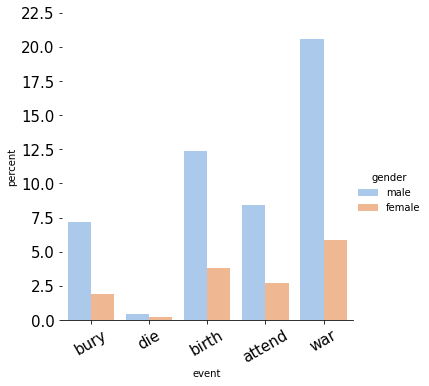

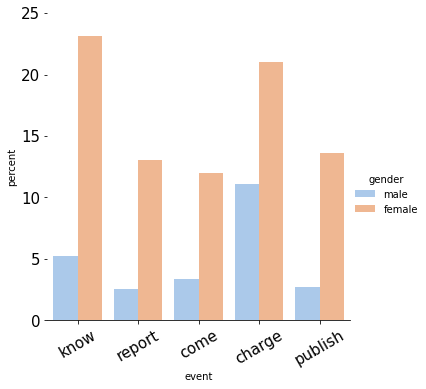

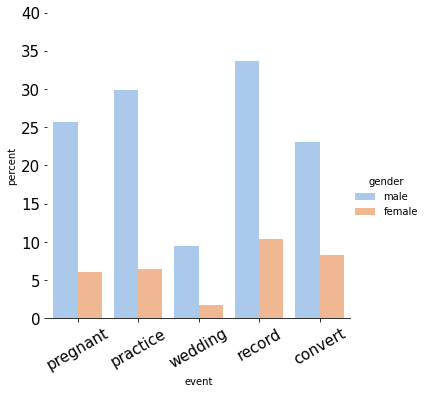

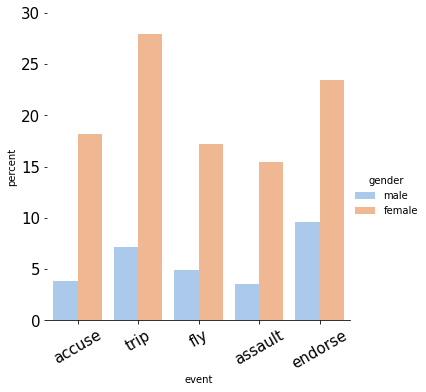

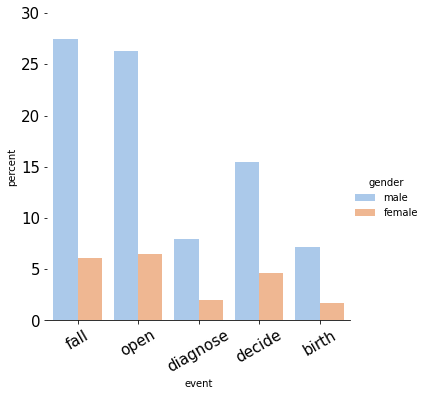

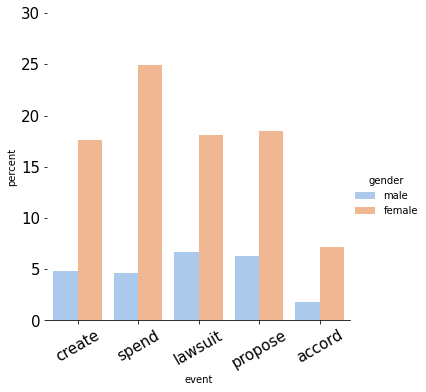

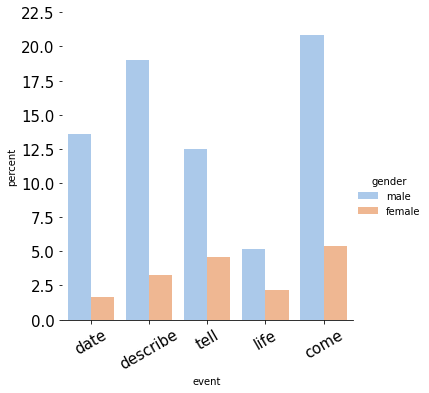

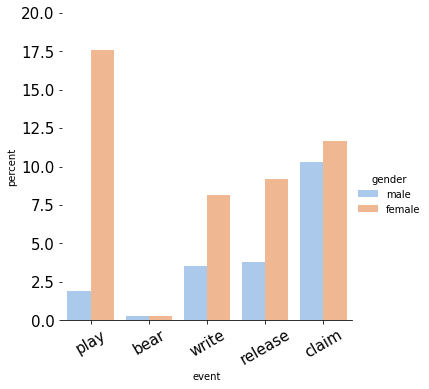

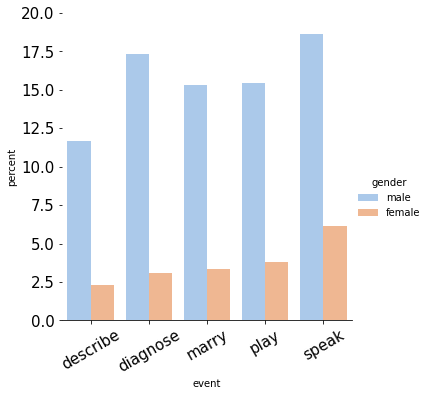

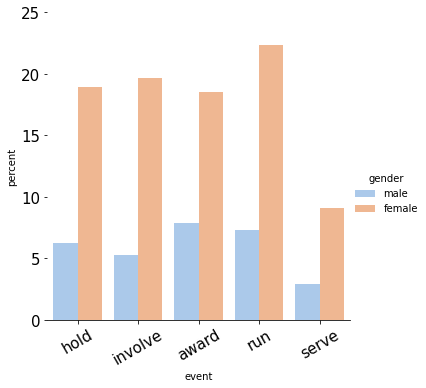

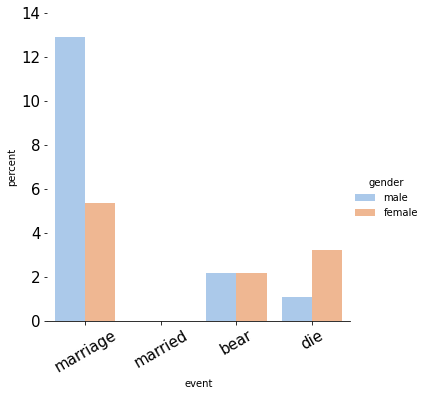

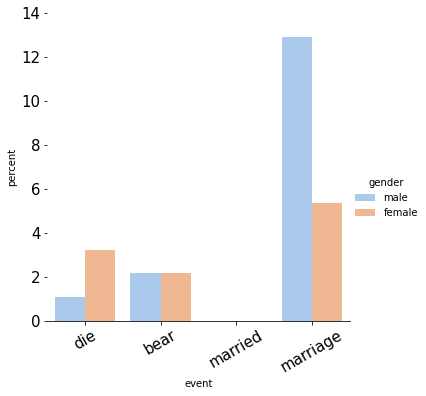

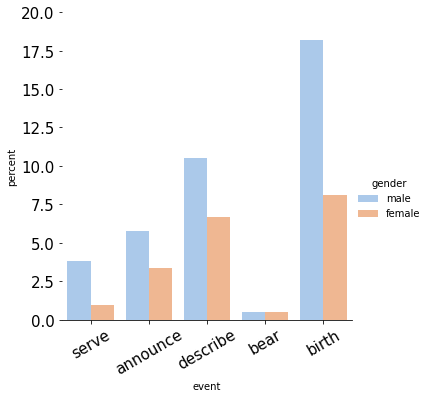

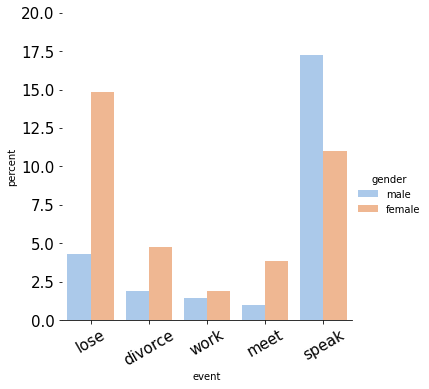

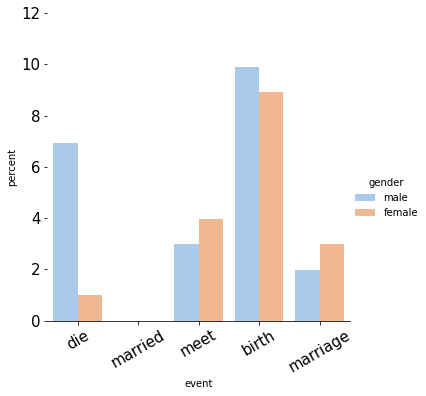

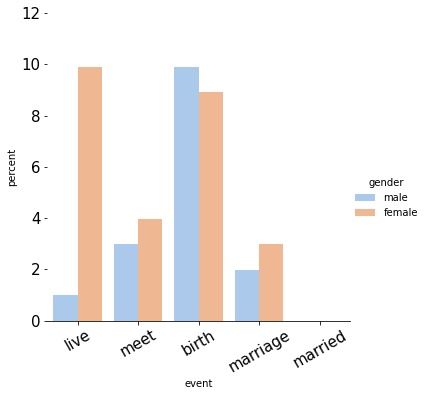

In [27]:
import seaborn as sns
import operator
import matplotlib.pyplot as plt
for occu in new_occupations:
    print("Occupation: ", occu)
    m_dict_occu, f_dict_occu = odds_ratio(cali_result[occu]["F"], cali_result[occu]["M"])
    print("male: ", list(m_dict_occu.keys())[:10])
    print("female: ", list(f_dict_occu.keys())[:10])
    female_events = list(f_dict_occu.keys())[:5]
    male_events = list(m_dict_occu.keys())[:5]
    
    sorted_counter_f_pl = {k: v for k, v in sorted(cali_result[occu]["F"].items(), key=lambda item: item[1], reverse=True)}
    sorted_counter_m_pl = {k: v for k, v in sorted(cali_result[occu]["M"].items(), key=lambda item: item[1], reverse=True)}
    m_topic_pl = list(sorted_counter_m_pl.keys())
    f_topic_pl = list(sorted_counter_f_pl.keys())
    for gender in ["F", "M"]:
        position = []
        if gender == "F":
            select_events = female_events
        else:
            select_events = male_events
        
        for m_topic in select_events:
            position.append({
                "percent": m_topic_pl.index(m_topic) / len(m_topic_pl) * 100,
                "gender": "male",
                "event": m_topic
                })
            position.append({
                "percent": f_topic_pl.index(m_topic) / len(m_topic_pl) * 100,
                "gender": "female",
                "event": m_topic
                })

        df = pd.DataFrame(position)
        g = sns.catplot(x='event', y='percent', hue='gender', data=df, kind='bar', palette = sns.color_palette("pastel"))
        g.set_xticklabels(fontsize = 15, rotation=30)
        g.set_yticklabels(fontsize = 15)
        g.despine(left=True)    
        # JULIE edits: don't need to save, just display
        
#         g.savefig(f"pl_figs/{occu}_{gender}.pdf", dpi=1000)
plt.show()

In [30]:
events='''Occupation:  writers
male:  ['know', 'report', 'come', 'charge', 'publish', 'claim', 'suffer', 'return', 'state', 'describe']
female:  ['bury', 'birth', 'attend', 'war', 'grow', 'serve', 'appear', 'raise', 'begin', 'divorce']
Occupation:  acting
male:  ['accuse', 'trip', 'fly', 'assault', 'endorse', 'meeting', 'donate', 'fight', 'arrest', 'found']
female:  ['pregnant', 'practice', 'wedding', 'record', 'convert', 'honor', 'gain', 'retire', 'rap', 'bring']
Occupation:  comedians
male:  ['visit', 'create', 'spend', 'propose', 'lawsuit', 'accord', 'arrest', 'find', 'sell', 'admit']
female:  ['feel', 'birth', 'fall', 'open', 'decide', 'date', 'diagnose', 'tweet', 'study', 'turn']
Occupation:  podcasters
male:  ['play', 'write', 'bear', 'release', 'claim', 'birth', 'divorce', 'meet', 'announce', 'work']
female:  ['date', 'describe', 'tell', 'life', 'come', 'leave', 'engage', 'live', 'start', 'reside']
Occupation:  dancers
male:  ['hold', 'involve', 'award', 'run', 'serve', 'adopt', 'charge', 'suit', 'struggle', 'perform']
female:  ['marry', 'describe', 'diagnose', 'expect', 'speak', 'post', 'attend', 'come', 'play', 'reside']
Occupation:  artists
male:  ['die', 'bear', 'married', 'marriage']
female:  ['marriage', 'married', 'bear', 'die']
Occupation:  chefs
male:  ['birth', 'lose', 'divorce', 'speak', 'meet', 'work', 'diagnose', 'wedding', 'write', 'engage']
female:  ['death', 'serve', 'announce', 'describe', 'bear', 'die', 'life', 'state', 'marriage', 'live']
Occupation:  musicians
male:  ['live', 'meet', 'birth', 'marriage', 'married', 'die']
female:  ['die', 'married', 'meet', 'birth', 'marriage', 'live']'''

In [31]:
import ast
occu_gender_events = {}
for line in events.split('\n'):
    if line.startswith('Occupation'):
        occu = line[len('Occupation:  '):]
    if line.startswith('male'):
        evs = ast.literal_eval(line[len('male:  '):])
        occu_gender_events[(occu, 'male')] = evs
    elif line.startswith('female'):
        evs = ast.literal_eval(line[len('female:  '):])
        occu_gender_events[(occu, 'female')] = evs
occu_gender_events

{('writers', 'male'): ['know',
  'report',
  'come',
  'charge',
  'publish',
  'claim',
  'suffer',
  'return',
  'state',
  'describe'],
 ('writers', 'female'): ['bury',
  'birth',
  'attend',
  'war',
  'grow',
  'serve',
  'appear',
  'raise',
  'begin',
  'divorce'],
 ('acting', 'male'): ['accuse',
  'trip',
  'fly',
  'assault',
  'endorse',
  'meeting',
  'donate',
  'fight',
  'arrest',
  'found'],
 ('acting', 'female'): ['pregnant',
  'practice',
  'wedding',
  'record',
  'convert',
  'honor',
  'gain',
  'retire',
  'rap',
  'bring'],
 ('comedians', 'male'): ['visit',
  'create',
  'spend',
  'propose',
  'lawsuit',
  'accord',
  'arrest',
  'find',
  'sell',
  'admit'],
 ('comedians', 'female'): ['feel',
  'birth',
  'fall',
  'open',
  'decide',
  'date',
  'diagnose',
  'tweet',
  'study',
  'turn'],
 ('podcasters', 'male'): ['play',
  'write',
  'bear',
  'release',
  'claim',
  'birth',
  'divorce',
  'meet',
  'announce',
  'work'],
 ('podcasters', 'female'): ['date',


In [32]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers",  "chefs"]
for occu in new_occupations:
    print(occu.capitalize(), '& F & &  ', ', '.join(occu_gender_events[(occu, 'female')][:5]), '\\\\')
    print('       & M & & ', ', '.join(occu_gender_events[(occu, 'male')][:5]), '\\\\')

Writers & F & &   bury, birth, attend, war, grow \\
       & M & &  know, report, come, charge, publish \\
Acting & F & &   pregnant, practice, wedding, record, convert \\
       & M & &  accuse, trip, fly, assault, endorse \\
Comedians & F & &   feel, birth, fall, open, decide \\
       & M & &  visit, create, spend, propose, lawsuit \\
Podcasters & F & &   date, describe, tell, life, come \\
       & M & &  play, write, bear, release, claim \\
Dancers & F & &   marry, describe, diagnose, expect, speak \\
       & M & &  hold, involve, award, run, serve \\
Chefs & F & &   death, serve, announce, describe, bear \\
       & M & &  birth, lose, divorce, speak, meet \\


In [ ]:
pocaster male bear

In [37]:
from WEAT.weat import run_test, load_embedding

In [39]:
glove_embeddings = load_embedding('WEAT/embeddings/glove.840B.300d.processed.txt')
w2v_embeddings = load_embedding('WEAT/embeddings/GoogleNews-vectors-negative300.bin')

WEAT/embeddings/glove.840B.300d.processed.txt
WEAT/embeddings/GoogleNews-vectors-negative300.bin


In [40]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
config = {}
config['A'] = ["male", "man", "boy", "brother", "he", "him", "his", "son", "father", "uncle", "grandfather"]
config['B'] = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter", "mother", "aunt", "grandmother"]

for occu in new_occupations:
    config['X'] = occu_gender_events[(occu, 'male')]
    config['Y'] = occu_gender_events[(occu, 'female')]
    glove_weat = run_test(config, glove_embeddings)
    w2v_weat = run_test(config, w2v_embeddings)
    print(f'{occu} glove {glove_weat[0]:.2f} w2v {w2v_weat[0]:.2f}')
    

writers glove 0.58 w2v 0.56
acting glove 0.06 w2v -0.08
comedians glove 0.55 w2v 0.28
podcasters glove 0.26 w2v 0.02
dancers glove 0.41 w2v 0.04
artists glove 0.07 w2v -0.08
chefs glove -0.73 w2v -0.17
musicians glove -0.15 w2v 0.01


In [41]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
config = {}
config['A'] = ["male", "man", "boy", "brother", "he", "him", "his", "son", "father", "uncle", "grandfather"]
config['B'] = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter", "mother", "aunt", "grandmother"]

for occu in new_occupations:
    config['X'] = occu_gender_events[(occu, 'male')][:5]
    config['Y'] = occu_gender_events[(occu, 'female')][:5]
    glove_weat = run_test(config, glove_embeddings)
    w2v_weat = run_test(config, w2v_embeddings)
    print(f'{occu} glove {glove_weat[0]:.2f} w2v {w2v_weat[0]:.2f}')
    

writers glove 0.34 w2v 0.34
acting glove 0.49 w2v 0.20
comedians glove 0.10 w2v -0.19
podcasters glove 0.61 w2v 0.64
dancers glove 0.78 w2v 0.42
artists glove -0.10 w2v 0.10
chefs glove -0.99 w2v -0.60
musicians glove -0.24 w2v -0.36
